In [1]:
import sys
sys.path.append('/srv/share3/hagrawal9/project/sokoban/habitat-sim/')
sys.path.append('/srv/share3/hagrawal9/project/sokoban/habitat-api/')

In [3]:
cd '/srv/share3/hagrawal9/project/sokoban/habitat-api/'

/coc/pskynet3/hagrawal9/project/sokoban/habitat-api


In [4]:
import gzip
import habitat
import habitat_sim
import habitat_sim.bindings as hsim
import json
import matplotlib.pyplot as plt
import magnum as mn
import numpy as np
import os
import tqdm 

import habitat_sim

from PIL import Image
from typing import Any, Dict, List, Optional, Union

from habitat import Config, logger
from habitat import make_dataset
from habitat.core.simulator import AgentState
# from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.sims.habitat_simulator.habitat_simulator import HabitatSim
from habitat.utils.visualizations.utils import observations_to_image, images_to_video
from habitat.tasks.sokoban.sokoban_vis_utils import SokobanVisualization
from habitat.utils.visualizations.maps import *
from habitat.utils.geometry_utils import (
    angle_between_quaternions,
    quaternion_from_two_vectors,
)
# from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.tasks.utils import (
    cartesian_to_polar,
    quaternion_from_coeff,
    quaternion_rotate_vector
)

from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class, SokobanRLEnv
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.common.utils import (
    batch_obs,
    generate_video,
    linear_decay,
)
from habitat_baselines.config.default import get_config
from habitat_baselines.rl.ppo import PPO, PointNavBaselinePolicy

from habitat_sim.physics import MotionType
from habitat_sim.attributes import PhysicsObjectAttributes
from habitat_sim.helper import *


EPSILON = 1e-6


def action_to_one_hot(action: int) -> np.array:
    one_hot = np.zeros(len(HabitatSimActions), dtype=np.float32)
    one_hot[action] = 1
    return one_hot

%matplotlib inline

In [5]:
from examples.run_ortools import *

In [6]:
import habitat_sim

In [7]:
content_path = "data/datasets/sokoban/coda/v1/train/content/object_5_scene_12_episode_1_gibson2.json.gz"

In [8]:
config = get_config("habitat_baselines/config/sokoban/pickup_order_ddppo_obj_5_scene_100.yaml")

In [9]:
config.defrost()
config.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR']
config.NUM_PROCESSES = 1
config.TASK_CONFIG.ENVIRONMENT.MAX_EPISODE_STEPS = 1000
config.TASK_CONFIG.TASK.SENSORS = ['OBJECT_GOAL', 'GRIPPED_OBJECT_SENSOR']
config.TASK_CONFIG.TASK.POSSIBLE_ACTIONS = ['STOP', 'MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT', 'GRAB_RELEASE']
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ['object_5_scene_28_episode_1000_gibson']
config.TASK_CONFIG.ENVIRONMENT.ITERATOR_OPTIONS.SHUFFLE = False
config.freeze()

In [10]:
dataset = make_dataset(config.TASK_CONFIG.DATASET.TYPE, config=config.TASK_CONFIG.DATASET)

2020-07-14 05:11:28,109 Initializing dataset Sokoban-v0


In [10]:
# env.close()

In [22]:
env.close()

In [23]:
env = SokobanRLEnv(config=config, dataset=dataset)

2020-07-14 05:34:17,152 initializing sim SokobanSim-v0


seed: 100


2020-07-14 05:34:18,890 Initializing task Sokoban-v0


Possible Actions: OrderedDict([('STOP', <habitat.tasks.nav.nav.StopAction object at 0x7fd89f61d128>), ('MOVE_FORWARD', <habitat.tasks.nav.nav.MoveForwardAction object at 0x7fd89f61d940>), ('TURN_LEFT', <habitat.tasks.nav.nav.TurnLeftAction object at 0x7fd89f61d7f0>), ('TURN_RIGHT', <habitat.tasks.nav.nav.TurnRightAction object at 0x7fd89f61d0b8>), ('GRAB_RELEASE', <habitat.tasks.sokoban.sokoban_task.GrabOrReleaseAction object at 0x7fd89f61da58>)])


In [24]:
len(dataset.episodes)

28000

In [ ]:
count = 0
failed_pickup_order = 0
failed_episodes = []

demonstrations = []
pbar = tqdm.tqdm(range(len(env.episodes)))
for i in pbar:
    obs = env.reset()
    sim = env._env._sim._sim
    sim.recompute_navmesh(
        sim.pathfinder, 
        sim.navmesh_settings,
        include_static_objects=False
    )
    route_indexes, pickup_order = find_shortest_path_for_multiple_objects(env, sim, sim.pathfinder)
    images = []
    
#     if int(env.current_episode.episode_id) not in failed_ids:
#         continue
    if pickup_order is None:
        failed_pickup_order += 1
        failed_episodes.append(env.current_episode)
        pickup_order = []
        # break
#         order = np.arange(len(env.habitat_env.current_episode.objects)).tolist()
#         pickup_order = random.shuffle(order)
#         continue
    
    pbar.set_description("EpisodeID:{}, order: {}, fcounter:{}".format(env.current_episode.scene_id, pickup_order, failed_pickup_order))
    
    dem = {}
    dem['episode_id'] = env.habitat_env.current_episode.episode_id
    dem['actions'] = []
    dem['is_grab_success'] = False
    dem['pickup_order'] = pickup_order
    
#     for obj_id in pickup_order:
#         val, obs, reward, done, infos, dem, images = shortest_path_example(config.TASK_CONFIG, env, "exact_gradient", obj_id, images, dem)
        
#         if val == False:
#             break
    
    
#     if val == False or done == False:
#         count += 1
#         print("pickup order: {}; current_id: {}".format(pickup_order, obj_id))
#         print("Infos:", infos['object_distance_to_goal'])
#         print("Reason", dem['reason'])
#         print('failed: {}'.format(env.current_episode.episode_id))
        
#         images_to_video(images, 'data/videos', 'fail_trajectory'+str(dem['episode_id']))
        

#     images_to_video(images, 'data/videos', 'success_trajectory'+str(dem['episode_id']))
    
#     print("i: {}, id:{}, success: {}, count={}, done={}, dist_to_goal: {}".format(
#         i, dem['episode_id'], val, count, done, [x for x in infos['object_distance_to_goal'].values()]
#     ))
#     print('--- ')
    demonstrations.append(dem)
    

EpisodeID:data/scene_datasets/gibson_train_val/Hainesburg.glb, order: [3, 2, 1, 4], fcounter:12:   4%|▍         | 1154/28000 [05:23<2:03:35,  3.62it/s]     

In [ ]:
object_positions = [obj.position for obj in env.current_episode.objects]
goal_positions = [obj.position for obj in env.current_episode.goals]
env._env._sim.geodesic_distance(object_positions[0], object_positions[1])

In [28]:
len(failed_episodes)

1636

In [65]:
demonstrations_dict = {}
for demo in demonstrations:
    if 'infos' in demo:
        if 'object_goals' in demo['infos']:
            for k, v in demo['infos']['object_goals'].items():
                demo['infos']['object_goals'][k] = np.array(v).tolist()
                
    demonstrations_dict[demo['episode_id']] = demo

In [66]:
with gzip.open('data/datasets/sokoban/coda/v1/train/content/object_5_scene_28_episode_1000_gibson.json.gz', "rt") as f:
    episodes = json.load(f)

In [70]:
for episode_id,demo  in demonstrations_dict.items():
    episode_id = demo['episode_id']
    episodes['episodes'][int(episode_id)]['demonstrations'] = demo

In [73]:
failed_episode_ids = []
for ep in failed_episodes:
    failed_episode_ids.append(int(ep.episode_id))

In [96]:
new_episodes = []
for i, episode in enumerate(episodes['episodes']):
    if i in failed_episode_ids:
        new_episodes.append(episode)
        

In [97]:
with gzip.open('data/datasets/sokoban/coda/v1/train/content/failed_pickup_order_object_5_scene_28_episode_1000_gibson.json.gz', "wt") as f:
    json.dump({'episodes':new_episodes}, f)

In [ ]:
from typing import Tuple
from collections import defaultdict

In [ ]:
max_len = 0
for episode in episodes['episodes']:
    max_len = max(max_len, len(episode['demonstrations']['actions']))

In [ ]:
unfinished_count = 0
for episode in episodes['episodes']:
    if str(episode['demonstrations']['actions'][-1]) != 'GRAB_RELEASE':
        unfinished_count += 1
        print(episode['demonstrations']['actions'][-1])

In [ ]:
unfinished_count = 0
for episode in episodes['episodes']:
    if len(episode['objects']) >= 5:
        print(episode['episode_id'])

In [46]:
object_positions = [obj.position for obj in env.current_episode.objects]
goal_positions = [obj.position for obj in env.current_episode.goals]

In [47]:
print(object_positions)
print(goal_positions)

print(sim.get_translation(0))

[[-0.01146458089351654, -3.3642377853393555, -0.41631799936294556], [1.898006796836853, -3.3642377853393555, -5.286407470703125]]
[[-3.388432025909424, -3.3642377853393555, -1.74472177028656], [-5.9047088623046875, -3.3642377853393555, -5.7958083152771]]
Vector(0.118808, -3.36424, 0.764982)


In [48]:
sim = env._env._sim._sim
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.set_defaults()
navmesh_settings.agent_radius = 0.2
navmesh_settings.agent_height = 0.5
navmesh_settings.agent_max_climb = 0.1

sv = SokobanVisualization(sim, navmesh_settings, map_resolution=(1250, 1250), num_samples=20000, draw_border=True)
tdmap, mp_list, rw_list = sv.get_topdown_map()
mp_list = np.array(mp_list)
rw_list = np.array(rw_list)


In [49]:
top_down_map = colorize_topdown_map(tdmap)

In [50]:
top_down_map = sv.draw_topdown_map(object_positions, goal_positions)

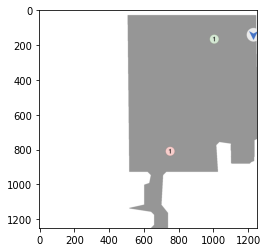

In [51]:
plt.imshow(top_down_map)